## Modeling - experiments

In [2]:
import gc
import os
import re
import math
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm as tqdm
from itertools import compress

from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile

import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, Conv1D, GRU
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import warnings

random.seed(0)
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = 9,6
warnings.filterwarnings('ignore')

In [3]:
# parameters settings
data_path = '../../../data/train/audio'
labels = os.listdir(data_path)
CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
SAMPLING_RATE = 16000
NOISE_RATIO = 0.1

In [4]:
# audio preprocessing functions
def pad_audio(samples):
    return np.pad(samples, pad_width=(SAMPLING_RATE - len(samples), 0), mode='constant', constant_values=(0, 0))


def chop_audio(samples):
    return samples[:SAMPLING_RATE]


def split_audio(sample_rate, samples):
    """ Splits audio file to multiple with (up to) fixed 1s length """
    duration = float(len(samples)/sample_rate)
    n_samples = math.ceil(duration)
    return np.array_split(samples, n_samples)

In [5]:
# label encoding
def assign_unknown_label(labels, classes=CLASSES):
    new_labels = []
    for label in labels:
        if label not in classes:
            new_labels.append('unknown')
        else:
            new_labels.append(label)
    return new_labels

def encode_labels(labels):
    return pd.get_dummies(pd.Series(labels))

In [6]:
# data preprocessing and plots
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)


def plot_model_history(history, title: str) -> None:
    """
    Plotting the learning curve of Keras model, broken down into loss curve and accuracy curve, 
    for both training and validation data.

    Args:
        history : Object returned by the .fit method of Keras model.
        title (str): Title of the plots.
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 

    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')

    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    fig.suptitle(title, size=15)
    plt.show()

In [7]:
# model framework
def rnn_network(input_dim, output_dim, rnn_layer, optimizer):

    input_data = Input(name='input', shape=input_dim, dtype='float32')

    x = Conv1D(filters=256, kernel_size=10, strides=4, name='conv1d')(input_data)
    x = BatchNormalization(name='b_norm')(x)
    x = Activation('relu', name='activation')(x)
    x = Dropout(DROPOUT, name='dropout_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=False, dropout=DROPOUT, name='rnn_1')(x)
    x = Dense(units=64, activation='relu', name='dense')(x)
    x = Dropout(DROPOUT, name='dropout_2')(x)

    output_data = Dense(units=output_dim, activation='softmax', name='softmax')(x)

    model = Model(inputs=input_data, outputs=output_data, name=str(rnn_layer).split(".")[-1].split("'")[0])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [8]:
def plot_heatmaps(models_results: list, title: str) -> None:
    """
    Plot heatmaps based on the confusion matrices of given models.

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], center=0.9, annot=True, cmap="cividis", linewidths=1, linecolor='black', ax=axes[i], annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matr(models_results: list, title: str) -> None:
    """
    Plot heatmaps based on the confusion matrices of given models.

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], annot=True, cmap="Blues", linewidths=1, linecolor='black', ax=axes[i], fmt='d', annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()

# <span style='font-family:Georgia'> 1. Data loading & preparation

## <span style='font-family:Georgia'> 1.1. Noisy data loading

In [9]:
label = '_background_noise_'
files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
one_sec_background_noise_specgrams = []

for file in tqdm(files):
    _, samples = wavfile.read(data_path + "/" + label + "/" + file)
    duration = float(len(samples)/SAMPLING_RATE)

    # Do not distinguish between noise classes
    one_sec_background_noise = split_audio(
            sample_rate=SAMPLING_RATE, samples=samples
        )
    
    for item in one_sec_background_noise:
        duration = float(len(item)/SAMPLING_RATE)
        if duration < 1: item = pad_audio(item)        
        
        one_sec_background_noise_specgrams.append(
            specgram(item, SAMPLING_RATE)
        )

  0%|          | 0/6 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.2. Noise-free data loading

In [10]:
validation_list = pd.read_csv('../../../data/train/validation_list.txt', sep="\t", header=None)[0].tolist()
testing_list = pd.read_csv('../../../data/train/testing_list.txt', sep="\t", header=None)[0].tolist()

In [11]:
print('Training: ', 64721 - len(validation_list) - len(testing_list))
print('Validation: ', len(validation_list))
print('Testing: ', len(testing_list))

Training:  51088
Validation:  6798
Testing:  6835


In [12]:
train_labels = []
train_specgrams = []
val_labels = []
val_specgrams = []
test_labels = []
test_specgrams = []

for label in tqdm([l for l in labels if l != '_background_noise_']):

    files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
    
    for file in tqdm(files):
        _, samples = wavfile.read(data_path + "/" + label + "/" + file)
        duration = float(len(samples)/SAMPLING_RATE)
                
        if duration < 1: samples = pad_audio(samples)
            
        if (label + "/" + file) in validation_list: 
            val_labels.append(label)
            val_specgrams.append(specgram(samples, SAMPLING_RATE))
        elif (label + "/" + file) in testing_list: 
            test_labels.append(label)
            test_specgrams.append(specgram(samples, SAMPLING_RATE))
        else:
            train_labels.append(label)
            train_specgrams.append(specgram(samples, SAMPLING_RATE))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/1731 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2359 [00:00<?, ?it/s]

  0%|          | 0/2352 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/1742 [00:00<?, ?it/s]

  0%|          | 0/1750 [00:00<?, ?it/s]

  0%|          | 0/2353 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2370 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/1745 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.3. Data labeling

### <span style='font-family:Georgia'> 1.3.1. Noise-free data split (for hyperparameters tuning)

In [13]:
X_train = np.array(train_specgrams)
X_val = np.array(val_specgrams)
X_test = np.array(test_specgrams)

Y_train = assign_unknown_label(train_labels)
Y_val = assign_unknown_label(val_labels)
Y_test = assign_unknown_label(test_labels)

Y_train = np.array(encode_labels(Y_train).values)
Y_val = np.array(encode_labels(Y_val).values)
Y_test = np.array(encode_labels(Y_test).values)

### <span style='font-family:Georgia'> 1.3.2. Approach 1 - taking `background_noise` observations as separate `silence` class

In [14]:
# Split noise into 3 disjoint subsets (train, valid & test sets)
N = 64721
valid_ratio = np.round(len(validation_list)/N, 2)
test_ratio = np.round(len(testing_list)/N, 2)
train_ratio = 1 - (valid_ratio+test_ratio)

sets_list = ["train", "val", "test"]
obs_split = np.array(random.choices(sets_list, weights=(train_ratio, valid_ratio, test_ratio), k=N))
train_mask, val_mask, test_mask = obs_split == "train", obs_split == "val", obs_split == "test"

In [15]:
train_noise = list(compress(one_sec_background_noise_specgrams, train_mask))
print(f'Number of observations assigned to train set: {len(train_noise)}')

val_noise = list(compress(one_sec_background_noise_specgrams, val_mask))
print(f'Number of observations assigned to validation set: {len(val_noise)}')

test_noise = list(compress(one_sec_background_noise_specgrams, test_mask))
print(f'Number of observations assigned to test set: {len(test_noise)}')

Number of observations assigned to train set: 303
Number of observations assigned to validation set: 48
Number of observations assigned to test set: 51


In [16]:
train_specgrams_1 = train_specgrams + train_noise
train_labels_1 = train_labels + ['silence' for i in range(len(train_noise))]

val_specgrams_1 = val_specgrams + val_noise
val_labels_1 = val_labels + ['silence' for i in range(len(val_noise))]

test_specgrams_1 = test_specgrams + test_noise
test_labels_1 = test_labels + ['silence' for i in range(len(test_noise))]

In [17]:
x_train_1 = np.array(train_specgrams_1)
print(x_train_1.shape)

x_val_1 = np.array(val_specgrams_1)
print(x_val_1.shape)

x_test_1 = np.array(test_specgrams_1)
print(x_test_1.shape)

(51391, 99, 161)
(6846, 99, 161)
(6886, 99, 161)


In [18]:
classes=CLASSES+['silence']

y_train_1 = assign_unknown_label(train_labels_1, classes=classes)
print(np.unique(y_train_1))

y_val_1 = assign_unknown_label(val_labels_1, classes=classes)
print(np.unique(y_val_1))

y_test_1 = assign_unknown_label(test_labels_1, classes=classes)
print(np.unique(y_test_1))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']


In [19]:
del train_specgrams_1, val_specgrams_1, test_specgrams_1
del train_labels_1, val_labels_1, test_labels_1
gc.collect()

246

In [20]:
# Labels encoding
y_train_1 = np.array(encode_labels(y_train_1).values)
y_val_1 = np.array(encode_labels(y_val_1).values)
y_test_1 = np.array(encode_labels(y_test_1).values)

### <span style='font-family:Georgia'> 1.3.2. Approach 2 - noising the training subset(s) with the 'background_noise' class observations

In [21]:
train_labels_summary = pd.Series(train_labels).value_counts()
n = math.floor(NOISE_RATIO*train_labels_summary.sum())
noised_labels = random.choices(train_labels, k=n)

summary = pd.DataFrame(train_labels_summary, columns=["obs_cnt"])
summary["noise_cnt"] = pd.Series(noised_labels).value_counts()
summary["noise_ratio"] = summary["noise_cnt"] / summary["obs_cnt"]
summary

,obs_cnt,noise_cnt,noise_ratio
one,1892,204,0.107822
stop,1885,185,0.098143
seven,1875,173,0.092267
nine,1875,170,0.090667
two,1873,167,0.089162
zero,1866,166,0.088960
on,1864,183,0.098176
six,1863,181,0.097155
go,1861,163,0.087587
yes,1860,191,0.102688


In [22]:
train_specgrams_2 = train_specgrams + random.choices(one_sec_background_noise_specgrams, k=n)
train_labels_2 = train_labels + noised_labels

In [23]:
x_train_2 = np.array(train_specgrams_2)
print(x_train_2.shape)

(56196, 99, 161)


In [24]:
y_train_2 = assign_unknown_label(train_labels_2)
print(np.unique(y_train_2))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [25]:
# Labels encoding
y_train_2 = np.array(encode_labels(y_train_2).values)

In [26]:
del train_specgrams_2, train_labels_2
del train_specgrams, val_specgrams, test_specgrams
del train_labels, val_labels, test_labels

gc.collect()

75

# <span style='font-family:Georgia'> 2. Modeling

In [27]:
MIN_DELTA=1e-3
DROPOUT = 0.2

## <span style='font-family:Georgia'> 2.1. Tuning hyperparameters

### <span style='font-family:Georgia'> 2.1.1. Learning rate & batch size tuning

In [28]:
# hyperparameters set-up
INPUT_DIM = (X_train.shape[1], X_train.shape[2])
OUTPUT_DIM = Y_train.shape[1]

Y_test_classes = np.argmax(Y_test, axis=1)

ITER = 10
EPOCHS = 50
PATIENCE=int(EPOCHS/10)

In [29]:
learning_rate = [1e-5, 1e-4, 1e-3]
batch_size = [128, 256]

In [30]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

In [31]:
model1_acc_all, model2_acc_all, model3_acc_all = [], [], []

for lr in tqdm(learning_rate):
    model1_acc_lr, model2_acc_lr, model3_acc_lr = [], [], []
    
    for size in tqdm(batch_size):
        model1_acc_bs, model2_acc_bs, model3_acc_bs = [], [], []        
    
        for i in range(ITER):
            OPT = Adam(learning_rate=lr, clipnorm=1.0)
            # SimpleRNN
            model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
            K.clear_session()
            model1_history = model1.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )

            # LSTM
            model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
            K.clear_session()
            model2_history = model2.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )

            # GRU
            model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
            K.clear_session()
            model3_history = model3.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )
            
            # Save models predictions accuracies for each iteration
            y_pred_1 = model1.predict(X_test)
            y_pred_2 = model2.predict(X_test)
            y_pred_3 = model3.predict(X_test)
            y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
            y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
            y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)

            model1_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_1))
            model2_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_2))
            model3_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_3))

        model1_acc_lr.append(model1_acc_bs)
        model2_acc_lr.append(model2_acc_bs)
        model3_acc_lr.append(model3_acc_bs)
        
    # Save models results for each learning rate
    model1_acc_all.append(model1_acc_lr)
    model2_acc_all.append(model2_acc_lr)
    model3_acc_all.append(model3_acc_lr)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/50
400/400 [==============================] - 74s 176ms/step - loss: 1.8040 - accuracy: 0.5461 - val_loss: 1.5524 - val_accuracy: 0.6209
Epoch 2/50
400/400 [==============================] - 68s 169ms/step - loss: 1.5823 - accuracy: 0.6314 - val_loss: 1.5022 - val_accuracy: 0.6208
Epoch 3/50
400/400 [==============================] - 67s 168ms/step - loss: 1.5255 - accuracy: 0.6335 - val_loss: 1.4638 - val_accuracy: 0.6208
Epoch 4/50
400/400 [==============================] - 59s 147ms/step - loss: 1.4684 - accuracy: 0.6321 - val_loss: 1.4262 - val_accuracy: 0.6208
Epoch 5/50
400/400 [==============================] - 69s 173ms/step - loss: 1.4291 - accuracy: 0.6322 - val_loss: 1.4023 - val_accuracy: 0.6208
Epoch 6/50
400/400 [==============================] - 71s 178ms/step - loss: 1.3957 - accuracy: 0.6322 - val_loss: 1.3638 - val_accuracy: 0.6214
Epoch 1/50
400/400 [==============================] - 102s 238ms/step - loss: 1.4917 - accuracy: 0.6168 - val_loss: 1.3801 - val_a

400/400 [==============================] - 107s 251ms/step - loss: 1.6300 - accuracy: 0.5990 - val_loss: 1.4573 - val_accuracy: 0.6209
Epoch 2/50
400/400 [==============================] - 101s 251ms/step - loss: 1.4157 - accuracy: 0.6362 - val_loss: 1.3633 - val_accuracy: 0.6212
Epoch 3/50
400/400 [==============================] - 95s 237ms/step - loss: 1.3312 - accuracy: 0.6357 - val_loss: 1.2784 - val_accuracy: 0.6228
Epoch 4/50
400/400 [==============================] - 93s 231ms/step - loss: 1.2596 - accuracy: 0.6397 - val_loss: 1.2028 - val_accuracy: 0.6358
Epoch 5/50
400/400 [==============================] - 92s 229ms/step - loss: 1.1939 - accuracy: 0.6499 - val_loss: 1.1156 - val_accuracy: 0.6542
Epoch 6/50
400/400 [==============================] - 95s 238ms/step - loss: 1.1283 - accuracy: 0.6635 - val_loss: 1.0350 - val_accuracy: 0.6756
Epoch 7/50
400/400 [==============================] - 95s 237ms/step - loss: 1.0667 - accuracy: 0.6782 - val_loss: 0.9707 - val_accuracy: 0

200/200 [==============================] - 76s 381ms/step - loss: 1.2254 - accuracy: 0.6367 - val_loss: 1.1654 - val_accuracy: 0.6289
Epoch 7/50
200/200 [==============================] - 78s 389ms/step - loss: 1.1765 - accuracy: 0.6400 - val_loss: 1.1094 - val_accuracy: 0.6321
Epoch 8/50
200/200 [==============================] - 75s 377ms/step - loss: 1.1327 - accuracy: 0.6453 - val_loss: 1.0495 - val_accuracy: 0.6433
Epoch 9/50
200/200 [==============================] - 77s 384ms/step - loss: 1.0786 - accuracy: 0.6560 - val_loss: 0.9809 - val_accuracy: 0.6740
Epoch 10/50
200/200 [==============================] - 78s 388ms/step - loss: 1.0205 - accuracy: 0.6718 - val_loss: 0.9163 - val_accuracy: 0.6984
Epoch 11/50
200/200 [==============================] - 76s 381ms/step - loss: 0.9674 - accuracy: 0.6884 - val_loss: 0.8598 - val_accuracy: 0.7221
Epoch 12/50
200/200 [==============================] - 78s 391ms/step - loss: 0.9098 - accuracy: 0.7058 - val_loss: 0.7999 - val_accuracy: 

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/50
400/400 [==============================] - 75s 179ms/step - loss: 1.5233 - accuracy: 0.6117 - val_loss: 1.4038 - val_accuracy: 0.6206
Epoch 2/50
400/400 [==============================] - 71s 177ms/step - loss: 1.2919 - accuracy: 0.6323 - val_loss: 1.1608 - val_accuracy: 0.6228
Epoch 3/50
400/400 [==============================] - 70s 176ms/step - loss: 1.1653 - accuracy: 0.6351 - val_loss: 1.0690 - val_accuracy: 0.6372
Epoch 4/50
400/400 [==============================] - 69s 174ms/step - loss: 1.0535 - accuracy: 0.6545 - val_loss: 0.9153 - val_accuracy: 0.6862
Epoch 5/50
400/400 [==============================] - 72s 181ms/step - loss: 0.9363 - accuracy: 0.6868 - val_loss: 0.9076 - val_accuracy: 0.6806
Epoch 6/50
400/400 [==============================] - 70s 175ms/step - loss: 0.8193 - accuracy: 0.7251 - val_loss: 0.7385 - val_accuracy: 0.7560
Epoch 7/50
400/400 [==============================] - 76s 190ms/step - loss: 0.7302 - accuracy: 0.7579 - val_loss: 0.6437 - val_ac

200/200 [==============================] - 64s 322ms/step - loss: 0.3874 - accuracy: 0.8816 - val_loss: 0.3995 - val_accuracy: 0.8785
Epoch 18/50
200/200 [==============================] - 60s 299ms/step - loss: 0.3709 - accuracy: 0.8850 - val_loss: 0.4010 - val_accuracy: 0.8773
Epoch 19/50
200/200 [==============================] - 65s 326ms/step - loss: 0.3529 - accuracy: 0.8914 - val_loss: 0.3752 - val_accuracy: 0.8917
Epoch 20/50
200/200 [==============================] - 64s 321ms/step - loss: 0.3355 - accuracy: 0.8984 - val_loss: 0.3514 - val_accuracy: 0.8935
Epoch 21/50
200/200 [==============================] - 61s 306ms/step - loss: 0.3257 - accuracy: 0.9023 - val_loss: 0.3390 - val_accuracy: 0.8960
Epoch 22/50
200/200 [==============================] - 61s 307ms/step - loss: 0.3140 - accuracy: 0.9047 - val_loss: 0.3613 - val_accuracy: 0.8901
Epoch 23/50
200/200 [==============================] - 63s 316ms/step - loss: 0.3042 - accuracy: 0.9068 - val_loss: 0.3467 - val_accurac

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/50
400/400 [==============================] - 79s 186ms/step - loss: 1.3541 - accuracy: 0.6316 - val_loss: 1.2416 - val_accuracy: 0.6189
Epoch 2/50
400/400 [==============================] - 67s 168ms/step - loss: 1.0379 - accuracy: 0.6620 - val_loss: 0.9916 - val_accuracy: 0.6998
Epoch 3/50
400/400 [==============================] - 70s 175ms/step - loss: 0.7657 - accuracy: 0.7568 - val_loss: 0.6713 - val_accuracy: 0.7835
Epoch 4/50
400/400 [==============================] - 70s 175ms/step - loss: 0.5956 - accuracy: 0.8115 - val_loss: 0.5349 - val_accuracy: 0.8269
Epoch 5/50
400/400 [==============================] - 70s 176ms/step - loss: 0.5054 - accuracy: 0.8439 - val_loss: 0.5941 - val_accuracy: 0.8132
Epoch 6/50
400/400 [==============================] - 69s 172ms/step - loss: 0.4355 - accuracy: 0.8710 - val_loss: 0.4363 - val_accuracy: 0.8647
Epoch 7/50
400/400 [==============================] - 67s 168ms/step - loss: 0.3937 - accuracy: 0.8865 - val_loss: 0.3959 - val_ac

200/200 [==============================] - 86s 428ms/step - loss: 0.1950 - accuracy: 0.9402 - val_loss: 0.2228 - val_accuracy: 0.9341
Epoch 14/50
200/200 [==============================] - 84s 422ms/step - loss: 0.1863 - accuracy: 0.9427 - val_loss: 0.2299 - val_accuracy: 0.9315
Epoch 15/50
200/200 [==============================] - 80s 401ms/step - loss: 0.1751 - accuracy: 0.9457 - val_loss: 0.2310 - val_accuracy: 0.9316
Epoch 16/50
200/200 [==============================] - 77s 386ms/step - loss: 0.1625 - accuracy: 0.9503 - val_loss: 0.2076 - val_accuracy: 0.9348
Epoch 17/50
200/200 [==============================] - 76s 381ms/step - loss: 0.1651 - accuracy: 0.9491 - val_loss: 0.2297 - val_accuracy: 0.9328
Epoch 18/50
200/200 [==============================] - 78s 392ms/step - loss: 0.1576 - accuracy: 0.9520 - val_loss: 0.1975 - val_accuracy: 0.9390
Epoch 19/50
200/200 [==============================] - 84s 418ms/step - loss: 0.1466 - accuracy: 0.9543 - val_loss: 0.2157 - val_accurac

### <span style='font-family:Georgia'> 2.1.2. Tuning results summary

In [32]:
acc_all = []
model_1_acc_lr, model_2_acc_lr, model_3_acc_lr = [], [], []

for i in range(len(learning_rate)):
    model_1_acc_bs, model_2_acc_bs, model_3_acc_bs = [], [], []
    for j in range(len(batch_size)):
        # mean over iterations (mean score for each learning_rate-batch_size pair)
        model_1_acc_bs.append(np.mean(model1_acc_all[i][j]))
        model_2_acc_bs.append(np.mean(model2_acc_all[i][j]))
        model_3_acc_bs.append(np.mean(model3_acc_all[i][j]))
        
    model_1_acc_lr.append(model_1_acc_bs)
    model_2_acc_lr.append(model_2_acc_bs)
    model_3_acc_lr.append(model_3_acc_bs)
        
    # mean over batch_sized (mean score for each learning_rate)
    acc_all.append([
        np.mean(model_1_acc_lr),
        np.mean(model_2_acc_lr),
        np.mean(model_3_acc_lr)
    ])

### <span style='font-family:Georgia'> Accuracy depending on both: Learning rate & Batch size

In [34]:
models_results = [
    pd.DataFrame(model_1_acc_lr, columns=batch_size, index=learning_rate),
    pd.DataFrame(model_2_acc_lr, columns=batch_size, index=learning_rate),
    pd.DataFrame(model_3_acc_lr, columns=batch_size, index=learning_rate)
]

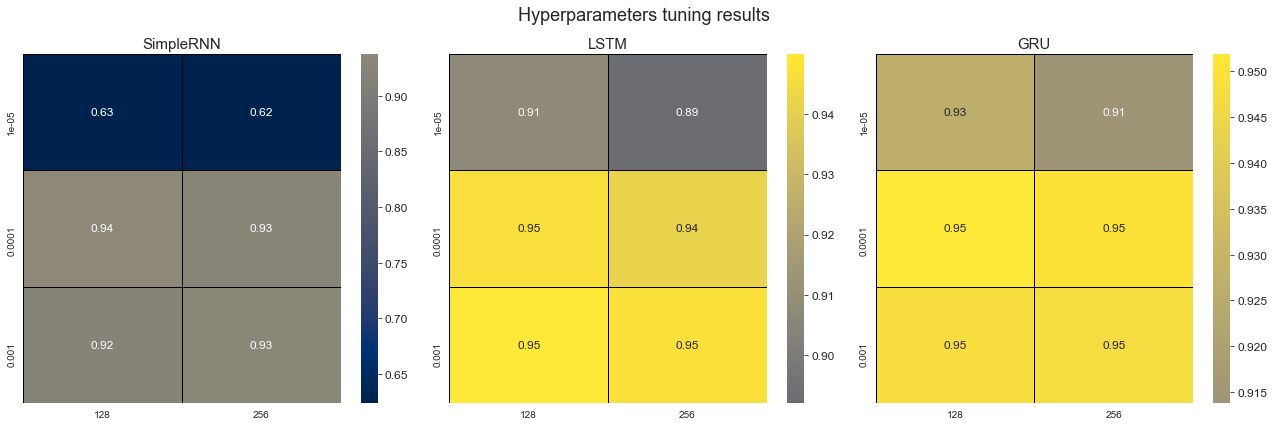

In [97]:
plot_heatmaps(models_results, title="Hyperparameters tuning results")

In [44]:
MODELS = ['SimpleRNN', 'LSTM', 'GRU']

for i in range(len(MODELS)):
    display(Markdown(f"#### {MODELS[i]} results summary:"))
    display(models_results[i])

#### SimpleRNN results summary:

,128,256
0.00001,0.625165,0.624287
0.00010,0.937235,0.926262
0.00100,0.921873,0.932114


#### LSTM results summary:

,128,256
0.00001,0.907388,0.892173
0.00010,0.946452,0.941770
0.00100,0.949817,0.946745


#### GRU results summary:

,128,256
0.00001,0.926554,0.913826
0.00010,0.951865,0.949525
0.00100,0.947769,0.947184


### <span style='font-family:Georgia'> Accuracy depending on both: Learning rate (mean over batch size)

In [37]:
results_acc = pd.DataFrame(acc_all)
results_acc.columns = ['SimpleRNN', 'LSTM', 'GRU']
results_acc.index = learning_rate
results_acc.index.name = "Learning rate"
results_acc_melted = pd.melt(results_acc.reset_index(), id_vars=['Learning rate'], value_vars=['SimpleRNN', 'LSTM', 'GRU'])
results_acc_melted.columns=['Learning rate', 'Model', 'Accuracy']
results_acc.reset_index(inplace=True)

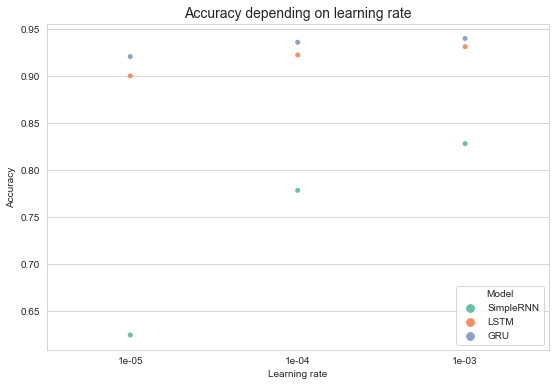

In [38]:
for j in range(results_acc_melted.shape[0]):
    results_acc_melted.loc[j, 'Learning rate'] = '{:.0e}'.format(results_acc_melted.loc[j, 'Learning rate'])
sns.stripplot(x="Learning rate", y="Accuracy", hue="Model",
               data=results_acc_melted, palette="Set2", dodge=False, jitter=0.0)    
plt.title("Accuracy depending on learning rate", size=14);

### <span style='font-family:Georgia'> 2.1.3. Tuned models overview

In [46]:
# Best parameters according to conducted experiments
LEARNING_RATES = [0.00010, 0.00100, 0.00010]
BATCH_SIZES = [128, 128, 128]

# SimpleRNN
OPT = Adam(learning_rate=LEARNING_RATES[0], clipnorm=1.0)
model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
K.clear_session()
model1_history = model1.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[0], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# LSTM
OPT = Adam(learning_rate=LEARNING_RATES[1], clipnorm=1.0)
model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
K.clear_session()
model2_history = model2.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[1], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# GRU
OPT = Adam(learning_rate=LEARNING_RATES[2], clipnorm=1.0)
model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
K.clear_session()
model3_history = model3.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[2], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# Save models predictions accuracies for each iteration
y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
y_pred_3 = model3.predict(X_test)
y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)

Epoch 1/50
400/400 [==============================] - 79s 174ms/step - loss: 1.5339 - accuracy: 0.6120 - val_loss: 1.3017 - val_accuracy: 0.6206
Epoch 2/50
400/400 [==============================] - 65s 162ms/step - loss: 1.2744 - accuracy: 0.6324 - val_loss: 1.1802 - val_accuracy: 0.6283
Epoch 3/50
400/400 [==============================] - 62s 156ms/step - loss: 1.1418 - accuracy: 0.6400 - val_loss: 1.0610 - val_accuracy: 0.6461
Epoch 4/50
400/400 [==============================] - 63s 156ms/step - loss: 1.0197 - accuracy: 0.6672 - val_loss: 0.8735 - val_accuracy: 0.7098
Epoch 5/50
400/400 [==============================] - 76s 190ms/step - loss: 0.8859 - accuracy: 0.7071 - val_loss: 0.7943 - val_accuracy: 0.7237
Epoch 6/50
400/400 [==============================] - 64s 159ms/step - loss: 0.7710 - accuracy: 0.7418 - val_loss: 0.6714 - val_accuracy: 0.7701
Epoch 7/50
400/400 [==============================] - 63s 157ms/step - loss: 0.6751 - accuracy: 0.7704 - val_loss: 0.5955 - val_ac

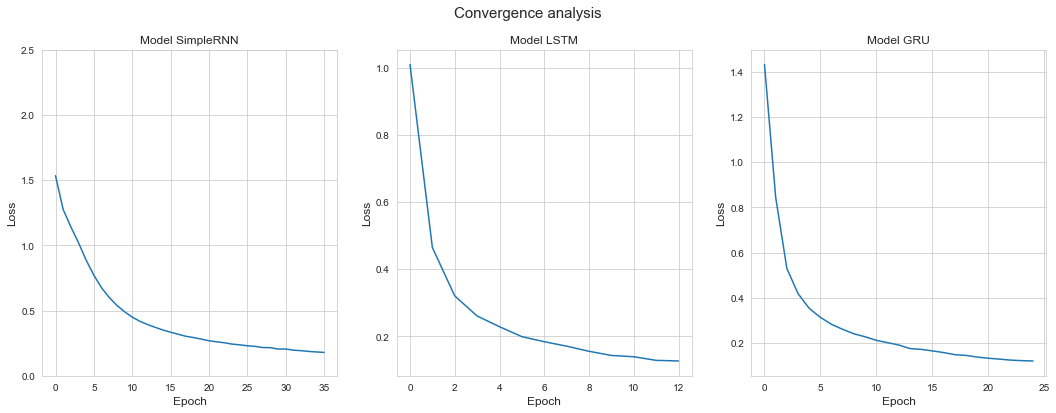

In [47]:
# Convergence analysis
models_history = [model1_history, model2_history, model3_history]

fig, axes = plt.subplots(1,3,figsize=(18,6))
models = ['1', '2', '3']
for i in range(3):
    model_name=MODELS[i]
    history = models_history[i]
    data_lr = history.history['loss']
    sns.lineplot(data=data_lr, ax=axes[i])
    if i == 0 : axes[i].set_ylim([0,2.5]) # due to huge loss values for 1e-2 (to make other lines visible)
    axes[i].set_title('Model '+model_name)
    axes[i].set_xlabel('Epoch', size=12)
    axes[i].set_ylabel('Loss', size=12)
fig.suptitle("Convergence analysis", size=15)
plt.show()

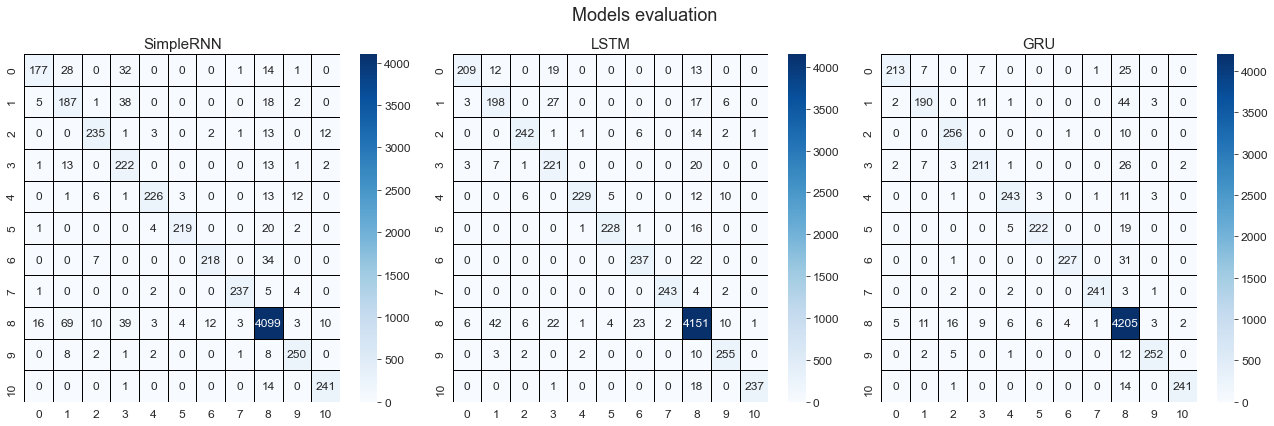

In [48]:
# Models evaluation - confusion matrices
models_results = [pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_1)),
                  pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_2)),
                  pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_3))]

plot_confusion_matr(models_results, 'Models evaluation')

## <span style='font-family:Georgia'> 2.2. Noise data handling

### <span style='font-family:Georgia'> 2.2.1. Approach 1 - taking `background_noise` observations as separate `silence` class

In [101]:
x_train, x_val, x_test = x_train_1, x_val_1, x_test_1
y_train, y_val, y_test = y_train_1, y_val_1, y_test_1

In [102]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

BATCH_SIZE = 128

In [109]:
# Models training
model1_stats = []
model1_acc = []
model2_stats = []
model2_acc = []
model3_stats = []
model3_acc = []

for i in range(ITER):
    # SimpleRNN
    OPT = Adam(learning_rate=LEARNING_RATES[0], clipnorm=1.0)
    model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
    K.clear_session()
    model1_history = model1.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # LSTM
    OPT = Adam(learning_rate=LEARNING_RATES[1], clipnorm=1.0)
    model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
    K.clear_session()
    model2_history = model2.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # GRU
    OPT = Adam(learning_rate=LEARNING_RATES[2], clipnorm=1.0)
    model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
    K.clear_session()
    model3_history = model3.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # Saving results
    y_test_classes = np.argmax(y_test, axis=1)
    
    model1_stats.append(model1_history)
    y_pred_1 = model1.predict(x_test)
    y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
    model1_acc.append(accuracy_score(y_test_classes, y_pred_classes_1))

    model2_stats.append(model2_history)
    y_pred_2 = model2.predict(x_test)
    y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
    model2_acc.append(accuracy_score(y_test_classes, y_pred_classes_2))
    
    model3_stats.append(model3_history)
    y_pred_3 = model3.predict(x_test)
    y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)
    model3_acc.append(accuracy_score(y_test_classes, y_pred_classes_3))

Epoch 1/50
402/402 [==============================] - 49s 119ms/step - loss: 1.5115 - accuracy: 0.6183 - val_loss: 1.3300 - val_accuracy: 0.6220
Epoch 2/50
402/402 [==============================] - 46s 116ms/step - loss: 1.2992 - accuracy: 0.6320 - val_loss: 1.2261 - val_accuracy: 0.6249
Epoch 3/50
402/402 [==============================] - 53s 133ms/step - loss: 1.1819 - accuracy: 0.6390 - val_loss: 1.0822 - val_accuracy: 0.6557
Epoch 4/50
402/402 [==============================] - 54s 134ms/step - loss: 1.0590 - accuracy: 0.6596 - val_loss: 0.9266 - val_accuracy: 0.6861
Epoch 5/50
402/402 [==============================] - 58s 146ms/step - loss: 0.9534 - accuracy: 0.6846 - val_loss: 0.8008 - val_accuracy: 0.7141
Epoch 6/50
402/402 [==============================] - 54s 135ms/step - loss: 0.8406 - accuracy: 0.7240 - val_loss: 0.6921 - val_accuracy: 0.7781
Epoch 7/50
402/402 [==============================] - 54s 134ms/step - loss: 0.7301 - accuracy: 0.7602 - val_loss: 0.6522 - val_ac

402/402 [==============================] - 41s 103ms/step - loss: 0.2498 - accuracy: 0.9246 - val_loss: 0.2965 - val_accuracy: 0.9157
Epoch 25/50
402/402 [==============================] - 42s 104ms/step - loss: 0.2423 - accuracy: 0.9273 - val_loss: 0.3010 - val_accuracy: 0.9109
Epoch 26/50
402/402 [==============================] - 45s 111ms/step - loss: 0.2382 - accuracy: 0.9286 - val_loss: 0.3140 - val_accuracy: 0.9128
Epoch 27/50
402/402 [==============================] - 42s 104ms/step - loss: 0.2325 - accuracy: 0.9310 - val_loss: 0.3231 - val_accuracy: 0.9115
Epoch 28/50
402/402 [==============================] - 42s 104ms/step - loss: 0.2250 - accuracy: 0.9344 - val_loss: 0.2793 - val_accuracy: 0.9157
Epoch 29/50
402/402 [==============================] - 45s 113ms/step - loss: 0.2186 - accuracy: 0.9349 - val_loss: 0.3368 - val_accuracy: 0.9053
Epoch 1/50
402/402 [==============================] - 60s 144ms/step - loss: 1.0387 - accuracy: 0.6900 - val_loss: 0.5884 - val_accuracy

In [110]:
# Models summary
approach1_acc_results = pd.DataFrame([model1_acc, model2_acc, model3_acc]).T
approach1_acc_results.columns=['SimpleRNN', 'LSTM', 'GRU']
approach1_acc_results_stats = approach1_acc_results.describe().T[['mean', 'std']]

In [111]:
model1_epochs = []
model2_epochs = []
model3_epochs = []
for i in range(ITER):
    model1_epochs.append(len(model1_stats[i].history['loss']))
    model2_epochs.append(len(model2_stats[i].history['loss']))
    model3_epochs.append(len(model3_stats[i].history['loss']))
    
approach1_acc_results_stats['epochs'] = [np.array(model1_epochs).mean(), np.array(model2_epochs).mean(),
                                      np.array(model3_epochs).mean()]
approach1_acc_results_stats

,mean,std,epochs
SimpleRNN,0.921798,0.009139,31.0
LSTM,0.949898,0.003697,21.0
GRU,0.952004,0.001540,30.5


### <span style='font-family:Georgia'> 2.2.2. Approach 2 - noising the training subset(s) with the `background_noise` class observations

In [114]:
x_train, x_val, x_test = x_train_2, X_val, X_test
y_train, y_val, y_test = y_train_2, Y_val, Y_test

In [115]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

BATCH_SIZE = 128

In [116]:
# Models training
model4_stats = []
model4_acc = []
model5_stats = []
model5_acc = []
model6_stats = []
model6_acc = []

for i in range(ITER):
    # SimpleRNN
    OPT = Adam(learning_rate=LEARNING_RATES[0], clipnorm=1.0)
    model4 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
    K.clear_session()
    model4_history = model4.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # LSTM
    OPT = Adam(learning_rate=LEARNING_RATES[1], clipnorm=1.0)
    model5 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
    K.clear_session()
    
    model5_history = model5.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # GRU
    OPT = Adam(learning_rate=LEARNING_RATES[2], clipnorm=1.0)
    model6 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
    K.clear_session()
    model6_history = model6.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # Saving results
    y_test_classes = np.argmax(y_test, axis=1)
    
    model4_stats.append(model4_history)
    y_pred_4 = model4.predict(x_test)
    y_pred_classes_4 = np.argmax(y_pred_4, axis=-1)
    model4_acc.append(accuracy_score(y_test_classes, y_pred_classes_4))

    model5_stats.append(model5_history)
    y_pred_5 = model5.predict(x_test)
    y_pred_classes_5 = np.argmax(y_pred_5, axis=-1)
    model5_acc.append(accuracy_score(y_test_classes, y_pred_classes_5))
    
    model6_stats.append(model6_history)
    y_pred_6 = model6.predict(x_test)
    y_pred_classes_6 = np.argmax(y_pred_6, axis=-1)
    model6_acc.append(accuracy_score(y_test_classes, y_pred_classes_6))

Epoch 1/50
440/440 [==============================] - 41s 91ms/step - loss: 1.5391 - accuracy: 0.6134 - val_loss: 1.3417 - val_accuracy: 0.6211
Epoch 2/50
440/440 [==============================] - 40s 92ms/step - loss: 1.3392 - accuracy: 0.6352 - val_loss: 1.2150 - val_accuracy: 0.6234
Epoch 3/50
440/440 [==============================] - 43s 98ms/step - loss: 1.2341 - accuracy: 0.6372 - val_loss: 1.0766 - val_accuracy: 0.6406
Epoch 4/50
440/440 [==============================] - 48s 109ms/step - loss: 1.1172 - accuracy: 0.6550 - val_loss: 0.9307 - val_accuracy: 0.6762
Epoch 5/50
440/440 [==============================] - 51s 115ms/step - loss: 0.9692 - accuracy: 0.7010 - val_loss: 0.8167 - val_accuracy: 0.7190
Epoch 6/50
440/440 [==============================] - 45s 102ms/step - loss: 0.8506 - accuracy: 0.7351 - val_loss: 0.6934 - val_accuracy: 0.7726
Epoch 7/50
440/440 [==============================] - 44s 101ms/step - loss: 0.7596 - accuracy: 0.7649 - val_loss: 0.6099 - val_accur

440/440 [==============================] - 49s 112ms/step - loss: 0.8352 - accuracy: 0.7359 - val_loss: 0.7199 - val_accuracy: 0.7596
Epoch 7/50
440/440 [==============================] - 45s 103ms/step - loss: 0.7395 - accuracy: 0.7695 - val_loss: 0.5945 - val_accuracy: 0.7991
Epoch 8/50
440/440 [==============================] - 48s 108ms/step - loss: 0.6678 - accuracy: 0.7934 - val_loss: 0.5301 - val_accuracy: 0.8279
Epoch 9/50
440/440 [==============================] - 48s 108ms/step - loss: 0.6123 - accuracy: 0.8116 - val_loss: 0.4653 - val_accuracy: 0.8463
Epoch 10/50
440/440 [==============================] - 45s 103ms/step - loss: 0.5763 - accuracy: 0.8246 - val_loss: 0.4608 - val_accuracy: 0.8447
Epoch 11/50
440/440 [==============================] - 48s 109ms/step - loss: 0.5403 - accuracy: 0.8389 - val_loss: 0.4027 - val_accuracy: 0.8717
Epoch 12/50
440/440 [==============================] - 46s 105ms/step - loss: 0.5067 - accuracy: 0.8497 - val_loss: 0.4216 - val_accuracy: 

In [119]:
# Models summary
approach2_acc_results = pd.DataFrame([model4_acc, model5_acc, model6_acc]).T
approach2_acc_results.columns=['SimpleRNN', 'LSTM', 'GRU']
approach2_acc_results_stats = approach2_acc_results.describe().T[['mean', 'std']]

In [120]:
model4_epochs = []
model5_epochs = []
model6_epochs = []
for i in range(ITER):
    model4_epochs.append(len(model4_stats[i].history['loss']))
    model5_epochs.append(len(model5_stats[i].history['loss']))
    model6_epochs.append(len(model6_stats[i].history['loss']))
    
approach2_acc_results_stats['epochs'] = [np.array(model4_epochs).mean(), np.array(model5_epochs).mean(),
                                      np.array(model6_epochs).mean()]
approach2_acc_results_stats

,mean,std,epochs
SimpleRNN,0.937527,0.004345,46.5
LSTM,0.951426,0.003517,22.5
GRU,0.951280,0.002483,27.5
